# Around Black-Scholes

We offer you the following practical task on Black-Scholes model. 

Total score is <span style="color:blue">100</span>, which will be converted to $10\%$ of the course grade. You may also get <span style="color:blue">30</span> extra points as bonuses. You have $3$ weeks for this work. **Soft deadline is 31st of March, 16:45 MSK.** Every $24$ hours during the next week **after** the deadline will give a penalty of $15\%$ of the total score. **Hard deadline is 7th of April, 16:45 MSK**.

The file must be sent to **victorantipov99@gmail.com.** Please rename your file as **"SurnameName_HW1.ipynb"** before sending. 

If you have any questions feel free to ask in Telegram https://t.me/igortao or https://t.me/v_antipov.

#### Full name: Tokaeva Alexandra
#### Faculty: Mech-math MSU


In [1]:
%%sh
echo "Installing dependencies..."

# ACHTUNG! Be careful here, installing dependencies via pip can break conda environment!
# If you still don't have these libs, uncomment lines below and run cell or install them manually.

pip install --user -U pip
pip install --user -U pandas numpy matplotlib scipy ipywidgets

echo "Done!"

Installing dependencies...
Done!


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as sps
from scipy.optimize import root_scalar

from ipywidgets import interact
from ipywidgets import widgets

from dataclasses import dataclass, field
from typing import Union
from copy import deepcopy

/Users/aleksandra/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


## Episode 1: The Price and It's Derivatives (20 points)

Consider prices of call and put options on stocks in Black-Scholes model:
$$C = S\Phi(d_1) - e^{-rT}K\Phi(d_2), \quad P = e^{-rT}K\Phi(-d_2) - S\Phi(-d_1),$$
where
$$
d_1 = \frac1{\sigma \sqrt{T}} \left( \ln \frac{S}{K} + \left( r + \frac{\sigma^2}2 \right) T \right), \quad 
d_2 = \frac1{\sigma \sqrt{T}} \left( \ln \frac{S}{K} + \left( r - \frac{\sigma^2}2 \right) T \right).
$$
Derive formulas for common greeks <span style="color:blue">(5 points)</span>.:
$$
\begin{aligned}
\Delta_c &= \frac{\partial C}{\partial S} =\Phi(d_1)\\
\Delta_p &= \frac{\partial P}{\partial S} =\Phi(d_1)-1\\
\gamma_c &= \frac{\partial^2 C}{\partial S^2} =\frac{\phi(d_1)}{S\sigma\sqrt{T}}\\
\gamma_p &= \frac{\partial^2 P}{\partial S^2} =\frac{\phi(d_1)}{S\sigma\sqrt{T}}\\
\theta_c &= -\frac{\partial C}{\partial T} =-\Phi(d_2)re^{-rT}K-\frac{\sigma S\phi(d_1)}{2\sqrt{T}}\\
\theta_p &= -\frac{\partial P}{\partial T} =(1-\Phi(d_2))re^{-rT}K-\frac{\sigma S\phi(d_1)}{2\sqrt{T}}\\
\nu_c &= \frac{\partial C}{\partial \sigma} =S\phi(d_1)\sqrt T\\
\nu_p &= \frac{\partial P}{\partial \sigma} =S\phi(d_1)\sqrt T\\
\rho_c &= \frac{\partial C}{\partial r} =Te^{-rT}K\Phi(d_2)\\
\rho_p &= \frac{\partial P}{\partial r} =-Te^{-rT}K\Phi(-d_2)
\end{aligned}
$$

Write functions for option price and greeks <span style="color:blue">(15 points)</span>.

In [3]:
@dataclass
class StockOption:
    strike_price: Union[float, np.ndarray]
    expiration_time: Union[float, np.ndarray]  # in years
    is_call: bool

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        

@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)

In [4]:
@dataclass
class MarketState:
    stock_price: Union[float, np.ndarray]
    volatility: Union[float, np.ndarray]  # sigma, annualized
    interest_rate: Union[float, np.ndarray]  # r, assume constant

In [5]:
# Your code

def Phi(x):
    return 0.5*(1+scipy.special.erf(x/np.sqrt(2)))

def phi(x):
    return np.exp(-x*x/2)/(2*np.sqrt(np.pi))

def price(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    # YOUR CODE HERE
    S=state.stock_price
    sigma=state.volatility
    r=state.interest_rate
    K=option.strike_price #np.linspace(50, 150, 150)
    T=option.expiration_time #np.linspace(0, 2, 150)
    d1=(np.log(S/K)+(r+0.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    if (option.is_call):
        return S*Phi(d1)-np.exp(-r*T)*K*Phi(d2)
    return np.exp(-r*T)*K*Phi(-d2)-S*Phi(-d1)
        

def delta(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    # YOUR CODE HERE
    S=state.stock_price
    sigma=state.volatility
    r=state.interest_rate
    K=option.strike_price
    T=option.expiration_time   
    d1=(np.log(S/K)+(r+0.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    if (option.is_call):
        return Phi(d1)
    return Phi(d1)-1
       

def gamma(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    # YOUR CODE HERE
    S=state.stock_price
    sigma=state.volatility
    r=state.interest_rate
    K=option.strike_price
    T=option.expiration_time
    d1=(np.log(S/K)+(r+0.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return phi(d1)/(S*sigma*np.sqrt(T))
    

def theta(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    # YOUR CODE HERE
    S=state.stock_price
    sigma=state.volatility
    r=state.interest_rate
    K=option.strike_price
    T=option.expiration_time
    d1=(np.log(S/K)+(r+0.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    if (option.is_call):
        return -r*np.exp(-r*T)*K*Phi(d2)-sigma*S*phi(d1)/(2*np.sqrt(T))
    return r*np.exp(-r*T)*K*Phi(-d2)-sigma*S*phi(d1)/(2*np.sqrt(T))
    
    
def vega(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    # YOUR CODE HERE
    S=state.stock_price
    sigma=state.volatility
    r=state.interest_rate
    K=option.strike_price
    T=option.expiration_time
    d1=(np.log(S/K)+(r+0.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return S*phi(d1)*np.sqrt(T)
    

def rho(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    # YOUR CODE HERE
    S=state.stock_price
    sigma=state.volatility
    r=state.interest_rate
    K=option.strike_price
    T=option.expiration_time
    d1=(np.log(S/K)+(r+0.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    if (option.is_call):
        return T*np.exp(-r*T)*K*Phi(d2)
    return -T*np.exp(-r*T)*K*Phi(-d2)


In [6]:
strikes = np.linspace(50, 150, 150)
times = np.linspace(0, 2, 150) #это время до экспирации 

calls = CallStockOption(strike_price=strikes.reshape(1, -1),
                        expiration_time=times.reshape(-1, 1))
puts = PutStockOption(strike_price=strikes.reshape(1, -1),
                      expiration_time=times.reshape(-1, 1))

In [7]:
market_state = MarketState(stock_price=100,
                           volatility=0.167,
                           interest_rate=0.1)

/Users/aleksandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


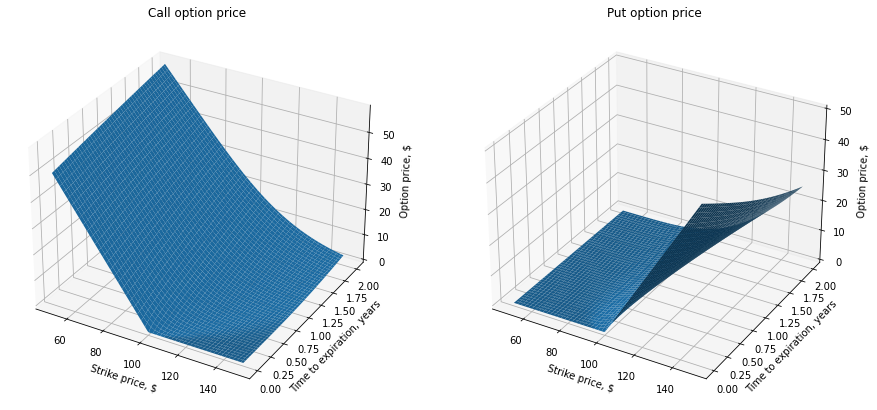

In [8]:
x, y = np.meshgrid(strikes, times)
call_price = price(calls, market_state)
put_price = price(puts, market_state)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

 ### Это мы теоретическим методом построили зависимость цены от страйка и времени до экспирации; а в пункте 2 мы построим эту же поверхность методом симуляций

In [9]:
def plot_all(type_: str = 'Call',
             time_to_expiration: float = 0.25,
             volatility: float = 0.1587,
             stock_price: float = 100.0,
             interest_rate: float = 0.0):
    opt = StockOption(strike_price=np.linspace(20, 200, 100),
                      expiration_time=time_to_expiration,
                      is_call=(type_ == 'Call'))
    state = MarketState(stock_price=stock_price,
                        volatility=volatility,
                        interest_rate=interest_rate)
    
    data = {
        'price': price(opt, state),
        'delta': delta(opt, state),
        'gamma': gamma(opt, state),
        'vega': vega(opt, state),
        'theta': theta(opt, state),
        'rho': rho(opt, state)
    }

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    for name, ax in zip(data, axs.flatten()):
        ax.plot(opt.strike_price, data[name])
        ax.set_title(name)
        ax.set_xlabel('Strike price')
        
    plt.show()

In [10]:
interact(plot_all,
         type_=widgets.Dropdown(options=['Call', 'Put'], value='Call', description='Option type'),
         time_to_expiration=widgets.FloatSlider(min=0.01, max=5.0, step=0.01, value=0.25, description='Time to expiration, years'),
         volatility=widgets.FloatSlider(min=0.1, max=2.0, step=0.01, value=0.1587, description='Volatility, annualized'),
         stock_price=widgets.FloatSlider(min=50.0, max=150.0, value=100.0, description='Stock price'),
         interest_rate=widgets.FloatSlider(min=0, max=0.2, step=0.005, value=0.0, description='Interest rate, annualized'));

interactive(children=(Dropdown(description='Option type', options=('Call', 'Put'), value='Call'), FloatSlider(…

## Episode 2: Monte-Carlo Strikes Back (50 points)

**1. Write down SDE for risk-neutral price process in Black-Scholes model and its solution <span style="color:blue">(5 points)</span>:**

$$
\begin{cases}
d S_t = r S_t dt+\sigma S_t dW_t\\\
S_{t_0} = S_0
\end{cases} \\
S_t = S_0 e^{(r-\frac{\sigma^2}{2})(t-t_0)+\sigma W_{t-t_0}}
$$

**2. Implement Monte-Carlo option pricing <span style="color:blue">(25 points)</span>**:

In [11]:
# Your code

def simulate_price(time: Union[float, np.ndarray],
                   n_simulations: int,
                   state: MarketState) -> np.ndarray:
    """Simulates price process evaluating it at given time points
        
    Args:
        time (float or np.darray): time point(s) at which the price shoud be evaluated.
        n_simulations (int): number of simulations.
        state (MarketState): initial market state to start from.
        
    Returns:
        np.ndarray: numpy array of shape (n_simulations, *np.shape(time)) with price.
    """
    
    # YOUR CODE HERE
    
    N=1000 #amt of steps between 0 and T
    otv=[]
    time=np.array([time]).flatten()
    S0=state.stock_price
    sigma=state.volatility
    r=state.interest_rate
    t=0
    St=S0*np.ones(n_simulations).reshape(n_simulations,-1)
    
    for T in time: #time may be a massive
        if (np.abs(T-t)<1e-15):
            otv.append(St.reshape(1,n_simulations).flatten())
            continue #the end: time is one number, not a massive
        
        n=N
        if (len(time)>1):
            n=int(N*(T-t)/(time[-1]-time[0]))
        
        t_grid=np.linspace(t,T,n)
        dt=t_grid[1]-t_grid[0]
        
        for t in t_grid:
            dWt=np.sqrt(dt)*np.random.normal(loc=0,scale=1,size=n_simulations).reshape(n_simulations,-1)
            dSt=r*St*dt+sigma*St*dWt
            St+=dSt
        otv.append(St.reshape(1,n_simulations).flatten())
        t=T
    return np.array(otv).T
    
    
    
def present_value(time: Union[float, np.ndarray],
                  value: Union[float, np.ndarray],
                  interest_rate: float) -> Union[float, np.ndarray]:
    """Calculates present value of payoff(s) occuread at given time(s)
    
    Args:
        time (float or np.ndarray): time(s) in years at which payoff occured
        value (float or np.ndarray): value(s) of the payoff(s)
        interest_rate (float): continuous annualized constant discount rate
    
    Returns:
        float or np.ndarray: continuously discounted value of the payoff
    """
    # YOUR CODE HERE
    
    return np.exp(-interest_rate*time).reshape(1,-1)*value

In [12]:
def mc_price(option: StockOption, state: MarketState, n_simulations: int = 10_000) -> Union[float, np.ndarray]:
    
    price = simulate_price(option.expiration_time, n_simulations, state) #10*150
    shape = option.strike_price.shape #1*150
    if option.is_call:
        payoff = np.maximum(0, np.subtract.outer(price,option.strike_price.flatten())) #10*150*150
    else:
        payoff = np.maximum(0, -np.subtract.outer(price,option.strike_price.flatten()))
        
    #print(option.expiration_time.shape) #(150*1)
    #print(payoff.mean(0).shape) #(150*150)
        
    return present_value(time=option.expiration_time,
                         value=payoff.mean(0), #150*150
                         interest_rate=state.interest_rate)

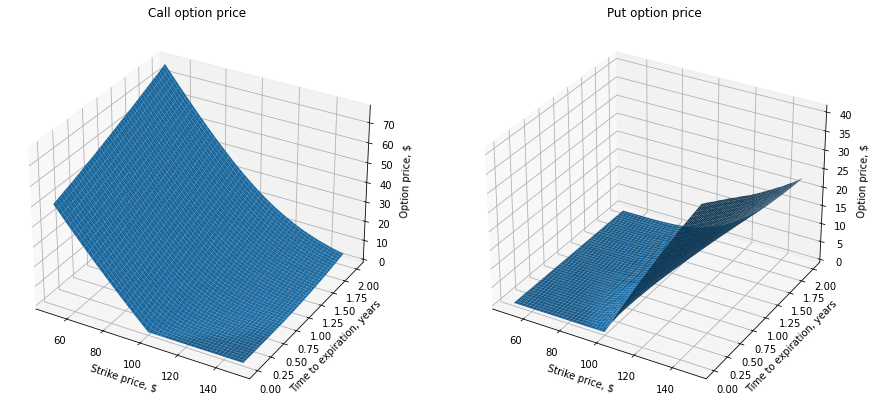

In [13]:
N_SIMULATIONS = 10_000
np.random.seed(42)

x, y = np.meshgrid(strikes, times)
call_price = mc_price(calls, market_state, N_SIMULATIONS)
put_price = mc_price(puts, market_state, N_SIMULATIONS)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

### Это мы построим эту же поверхность зависимости цены от страйка и времени до экспирации методом симуляций, и она совпала с поверхностью из пункта 1!

**3. Error Estimation <span style="color:blue">(20 points)</span>**

It is not sufficient to perform MC simulation, errors should also be estimated.
To obtain price confidence intervals Chebyshev's inequality can be used.
Let $\xi$ be the random variable, and we want to compute it's expectation using MC.
Let $\mu = \mathbb{E} [\xi]$ and $\sigma^2 = \mathrm{var}[\xi]$.
Consider $N$ i.i.d. copies of $\xi$. 
Then:
$$
\mathbb{P} \left( \left\lvert \frac{\xi_1 + \ldots \xi_N}N - \mu \right\rvert \ge \epsilon \right) \le \frac{\sigma^2}{N\epsilon^2}
$$

В качестве $\mu$, которое для которого мы хотим доверительный интервал, выступает $E(S_T-K)^{+}$ 

В качестве $\xi_i$ выступает i-я насимулированная $(S_T-K)^{+}$

$\mathbb{P} \left(\overline{(S_T-K)^{+}} -\epsilon \leq E(S_T-K)^{+} \leq \overline{(S_T-K)^{+}} +\epsilon \right) \geq \frac{\sigma^2}{N \epsilon^2}=0.95$

Поэтому возьмем $\epsilon=\frac{\sigma}{\sqrt {0.95 N}}$

Значение $\sigma$ мы не знаем, поэтому придется взять вместо $\sigma$ КОРЕНЬ из выборочной дисперсии $\frac{1}{N-1}\sum_{i=1}^{N} \left(\xi_i - \overline{\xi} \right)^2$

То есть 0.95-доверительный интервал для $E(S_T-K)^{+}$ имеет вид:

$\left[ \overline{\xi} - \frac{ \sqrt{ \frac{1}{N-1}\sum_{i=1}^{N} \left(\xi_i - \overline{\xi} \right)^2 }} {\sqrt{0.95N}}; \overline{\xi} + \frac{ \sqrt{ \frac{1}{N-1}\sum_{i=1}^{N} \left(\xi_i - \overline{\xi} \right)^2}} {\sqrt{0.95N}}\right]$

### Сначала делаем для кола

### Вставляем в оценку вместо сигмы корень из выборочной дисперсии

In [15]:
# YOUR CODE HERE
T=1
strikes = np.linspace(50, 150, 11)
callsWithOneT = CallStockOption(strike_price=strikes.reshape(1, -1),expiration_time=T)
market_state = MarketState(stock_price=100,
                           volatility=0.167,
                           interest_rate=0.1)

N=10000
S_prices=simulate_price(callsWithOneT.expiration_time, N, market_state)#N*1
ksis=np.maximum(0,S_prices-strikes) #N*len(strikes)=N*150
ksis=present_value(T,ksis,market_state.interest_rate) #we discount E(S_T-K)^+
real_price=price(callsWithOneT,market_state).flatten()
ksi_bar=ksis.mean(axis=0)
ksisMinusksiBar=ksis-ksi_bar.reshape(1,len(strikes))
VuborochnSrednee=(ksisMinusksiBar**2).sum(axis=0)/(N-1)
eps=np.sqrt(VuborochnSrednee)/np.sqrt(0.95*N)

for i in range(len(real_price)):
    print(i,ksi_bar[i]-eps[i], real_price[i], ksi_bar[i]+eps[i])

0 54.65749360472682 54.75813132615774 55.004794392267975
1 45.609119424366874 45.71013382348665 45.95642021190803
2 36.56938906310584 36.67392006398019 36.91629202275232
3 27.649438066177638 27.75596410565433 27.991615386484156
4 19.26914395202311 19.358000413325854 19.592449044054927
5 12.127753284602468 12.195904320810229 12.41122199771282
6 6.831700157479138 6.875588010205142 7.058655071111159
7 3.4453435868797153 3.4738870741118006 3.6119593688529146
8 1.5720610947822318 1.587023803270764 1.686252954024915
9 0.6629456777799287 0.6636387603697411 0.737304576782458
10 0.26884571345628655 0.25732840195885087 0.3149588267330064


### Видим, что настоящая цена попала в доверительный интервал, построенный на сонове выборочной дисперсии!

In practice we usually don't know the variance of $\xi$ and need to estimate it using sample variance.
But in BSM there exists analytical formula for European options payoffs' variances. 
Derive the variances of the call and put opions' final payoff (note the discounting):

$$
\mathrm{var}[e^{-rT}(S_T-K)^{+}] = S_0^2e^{\sigma^2 T} \Phi(d_3) -2KS_0 e^{-rT} \Phi(d_1) + K^2 e^{-2rT} \Phi(d_2) - {\left( S_0 \Phi(d_1)-e^{-rT}K\Phi(d_2) \right)}^2\\
$$

$$
d_1=\frac{\ln {\frac{S}{K}} + \left( r+ \frac{\sigma^2}{2} \right)T}{\sigma \sqrt{T}}
$$

$$
d_2=\frac{\ln {\frac{S}{K}} + \left( r- \frac{\sigma^2}{2} \right)T}{\sigma \sqrt{T}} = d_1-\sigma \sqrt{T}
$$

$$
d_3=\frac{\ln {\frac{S}{K}} + \left( r+ \frac{3 \sigma^2}{2} \right)T}{\sigma \sqrt{T}}=d_1+\sigma \sqrt{T}
$$

### А теперь вставляем в оценку вместо сигмы корень из настоящей дисперсии цены опциона и рисуем error-bar для доверительных интервалов, постороенных для настоящей дисперсии (а не выборочной)

Plot error bars for 10000 MC simulations for 11 strikes from 50 to 150 for 0.95 confidence intervals.

0 54.603081976314165 54.75813132615774 54.94816176161758
1 45.554718745735094 45.71013382348665 45.8997766314777
2 36.51562162887608 36.67392006398019 36.86009711952028
3 27.5996674891944 27.75596410565433 27.93919930044063
4 19.21257724566858 19.358000413325854 19.53338263896423
5 12.059636415055914 12.195904320810229 12.340489728296754
6 6.73277134426922 6.875588010205142 6.956839581382229
7 3.36874221396355 3.4738870741118006 3.5322302707028976
8 1.522063843399564 1.587023803270764 1.632754182064671
9 0.6446929258332073 0.6636387603697411 0.7154233798465466
10 0.2666413374576154 0.25732840195885087 0.3099285118654336


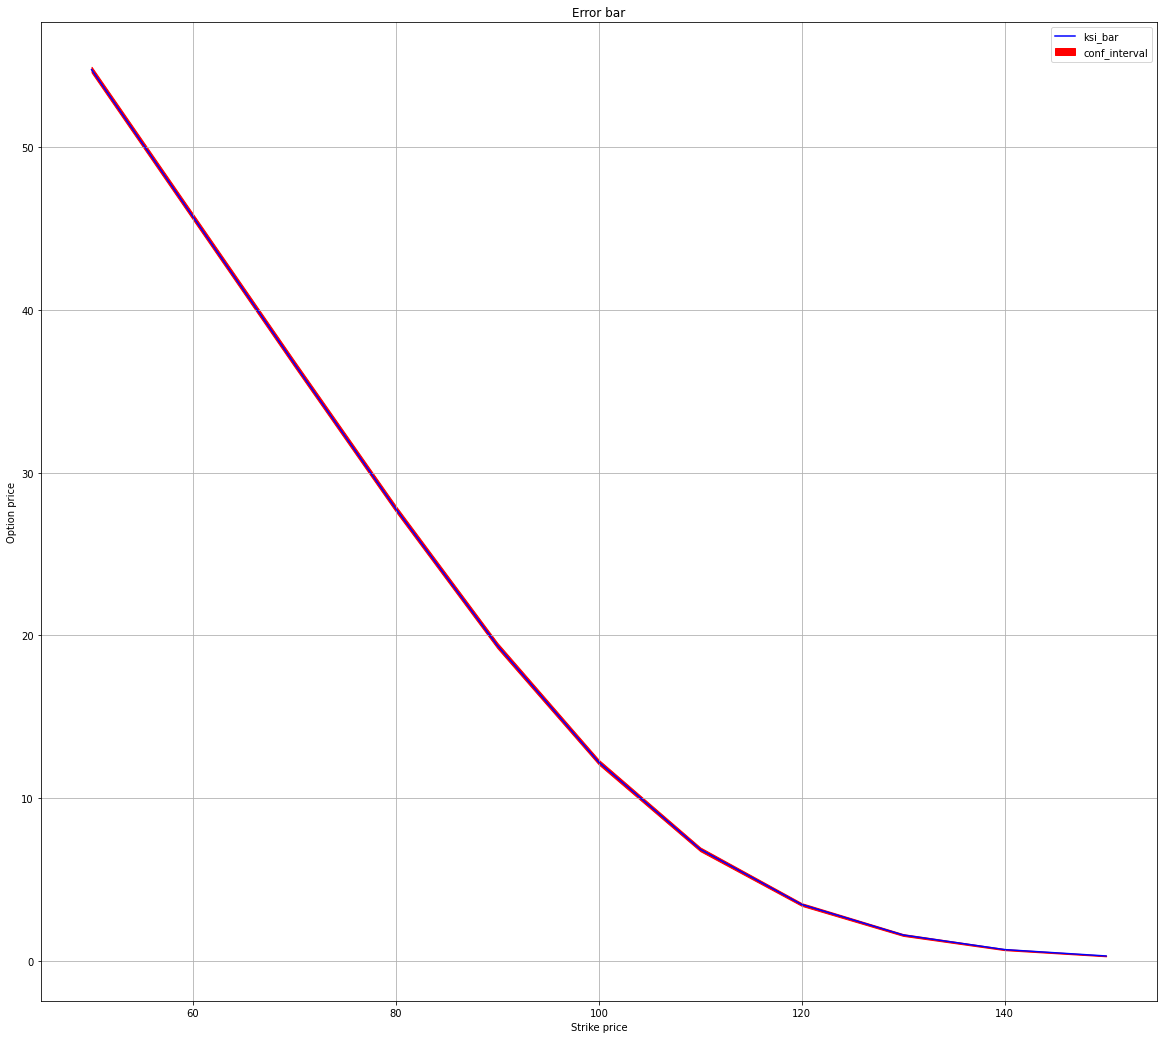

In [16]:
# YOUR CODE HERE

def VarCallOrPut(option: StockOption, state: MarketState)->Union[float,np.ndarray]:
    S=state.stock_price
    sigma=state.volatility
    r=state.interest_rate
    K=option.strike_price #np.linspace(50,150,150)
    T=option.expiration_time #T=1
    d1=(np.log(S/K)+(r+0.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    d3=(np.log(S/K)+(r+1.5*sigma*sigma)*T)/(sigma*np.sqrt(T))
    if option.is_call:
        return S*S*np.exp(sigma*sigma*T)*Phi(d3)-2*K*S*np.exp(-r*T)*Phi(d1)+K*K*np.exp(-2*r*T)*Phi(d2)-price(option,state)**2

    return S*S*np.exp(sigma*sigma*T)*Phi(-d3)-2*K*S*np.exp(-r*T)*Phi(-d1)+K*K*np.exp(-2*r*T)*Phi(-d2)-price(option,state)**2

def plot_error_bars(strikes,optionsWithOneT,market_state):
    N=10000
    S_prices=simulate_price(optionsWithOneT.expiration_time, N, market_state)#N*1
    if (optionsWithOneT.is_call):
        ksis=np.maximum(0,S_prices-strikes) #N*len(strikes)=N*150
    else:
        ksis=np.maximum(0,-S_prices+strikes)
    ksis=present_value(T,ksis,market_state.interest_rate) #we discount E(S_T-K)^+
    real_price=price(optionsWithOneT,market_state).flatten()
    ksi_bar=ksis.mean(axis=0)
    ksisMinusksiBar=ksis-ksi_bar.reshape(1,len(strikes))
    #VuborochnSrednee=(ksisMinusksiBar**2).sum(axis=0)/(N-1)
    eps=np.sqrt(VarCallOrPut(optionsWithOneT, market_state).flatten())/np.sqrt(0.95*N)
    left_border=[]
    right_border=[]

    for i in range(len(real_price)):
        print(i,ksi_bar[i]-eps[i], real_price[i], ksi_bar[i]+eps[i])
        left_border.append(ksi_bar[i]-eps[i])
        right_border.append(ksi_bar[i]+eps[i])

    fig,ax=plt.subplots(figsize=(20, 18))
    ax.plot(strikes,ksi_bar, color='b',label='ksi_bar')
    ax.fill_between(strikes, left_border, right_border,color='r',label='conf_interval')
    plt.title('Error bar')
    plt.xlabel('Strike price')
    plt.ylabel('Option price')
    ax.legend()
    ax.grid()
    plt.show()
    

T=1
strikes = np.linspace(50, 150, 11)
callsWithOneT = CallStockOption(strike_price=strikes.reshape(1, -1),expiration_time=T)
market_state = MarketState(stock_price=100,
                           volatility=0.167,
                           interest_rate=0.1)

plot_error_bars(strikes,callsWithOneT,market_state)

### Видим, что настоящая цена попала в доверительный интервал, построенный на основании настоящей дисперсии!

### Теперь делаем для пута

$$
\mathrm{var}[e^{-rT}(K-S_T)^{+}] = S_0^2e^{\sigma^2 T} \Phi(-d_3) -2KS_0 e^{-rT} \Phi(-d_1) + K^2 e^{-2rT} \Phi(-d_2) - {\left(e^{-rT}K\Phi(-d_2) - S_0 \Phi(-d_1) \right)}^2\\
$$

0 -2.5287069865973372e-05 2.2279557126901573e-06 2.5287069865973372e-05
1 0.0002586274719797507 0.0003789056442211145 0.0010547978749691446
2 0.00928901485079748 0.012539326497343128 0.014724460378029144
3 0.13008013475680613 0.142957548531089 0.1514554123687566
4 0.7576173748163809 0.7933680365622156 0.8144592142034227
5 2.595326358808391 2.679646124406169 2.7079362338762367
6 6.270759691990017 6.407703994160691 6.449010027487345
7 11.88188354949098 12.054377238426937 12.120814924049466
8 18.991137783520948 19.215888147945492 19.27600075022429
9 27.05503675708811 27.340877285404076 27.369357956109674
10 35.66868616895835 35.9829411073528 35.99945643215029


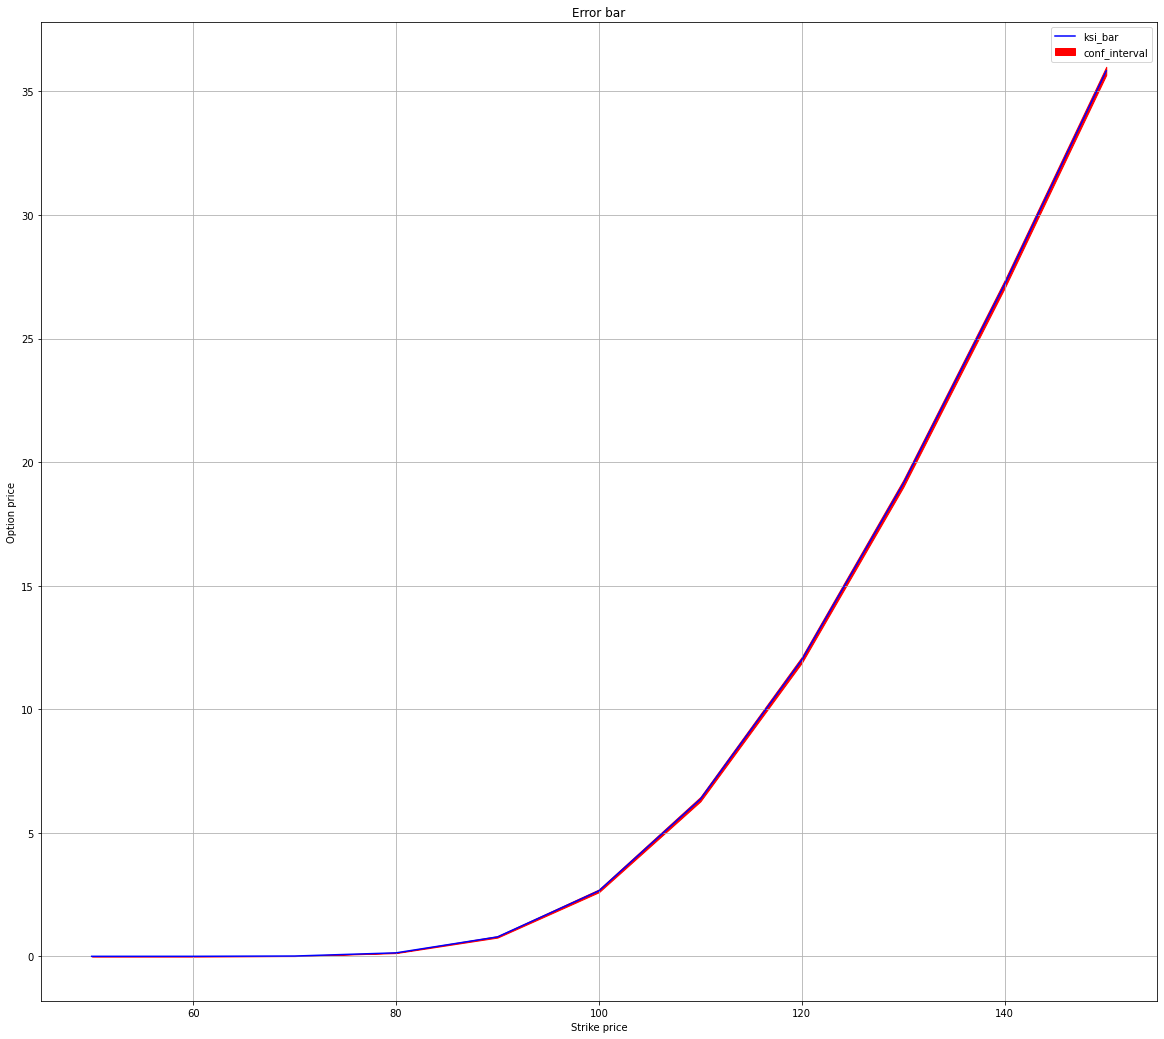

In [17]:
T=1
strikes = np.linspace(50, 150, 11)
putsWithOneT = PutStockOption(strike_price=strikes.reshape(1, -1),expiration_time=T)
market_state = MarketState(stock_price=100,
                           volatility=0.167,
                           interest_rate=0.1)

plot_error_bars(strikes,putsWithOneT,market_state)

### Видим, что настоящая цена попала в доверительный интервал, построенный на основании настоящей дисперсии!

## Episode 3: The Phantom Implied Volatility (30 points + 30 extra points)

**1. Vanilla Root Finding (30 points)**

Here you are to implement algorithm for computing implied volatility of option.
Volatility in MarketState that is passed to the IV function must be ignored.
Your algorithm should be stable! Comment on the results please.

Hint: use scipy library (https://docs.scipy.org/doc/scipy/reference/optimize.html).

In [18]:
def calc_iv(option: CallStockOption, state: MarketState, market_option_price: float):
    """Calculates implied volatility
    
    Args:
        option (CallStockOption): call option parameters, 
            call is used due to the uniqueness of the solution
        state (MarketState): market state, volatility parameter is ignored
        market_option_price (float): actual option price
    
    Returns:
        float: volatility that produced passed option price
    """
    
    # YOUR CODE HERE
    def f(sigma):
        stateWithThisVolatility=MarketState(stock_price=state.stock_price, volatility=sigma,interest_rate=state.interest_rate)
        return price(option,stateWithThisVolatility)-market_option_price
    
    def fprime(sigma):
        stateWithThisVolatility=MarketState(stock_price=state.stock_price, volatility=sigma,interest_rate=state.interest_rate)
        return vega(option,stateWithThisVolatility)
    
    #otv=root_scalar(f,method='newton',bracket=[0,100],x0=0.2,fprime=fprime) #it works but sometimes diverges
    otv=root_scalar(f,bracket=[0,100],method='brentq')
    return otv.root

In [19]:
df = pd.read_csv("calls.csv")
df

,strike,price,yahoo_iv,stock_price,time_to_expiration
0,150.0,288.73,0.8307,430.78,0.83
1,160.0,278.77,0.7858,430.78,0.83
2,190.0,242.60,0.5232,430.78,0.83
3,200.0,232.63,0.4950,430.78,0.83
4,250.0,183.87,0.4016,430.78,0.83
...,...,...,...,...,...
86,550.0,1.34,0.1594,430.78,0.83
87,560.0,1.02,0.1601,430.78,0.83
88,565.0,0.89,0.1605,430.78,0.83
89,600.0,0.42,0.1681,430.78,0.83


In [20]:
PLACEHOLDER_VOL = 0.2

In [21]:
market_state = MarketState(stock_price=df.at[0, "stock_price"],
                           volatility=PLACEHOLDER_VOL,
                           interest_rate=0.0)

In [22]:
for idx, row in df.iterrows():
    option = CallStockOption(strike_price=row["strike"],
                             expiration_time=row["time_to_expiration"])
    df.at[idx, "iv"] = calc_iv(option, market_state, row["price"])

/Users/aleksandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


Mean squared error: 0.00004


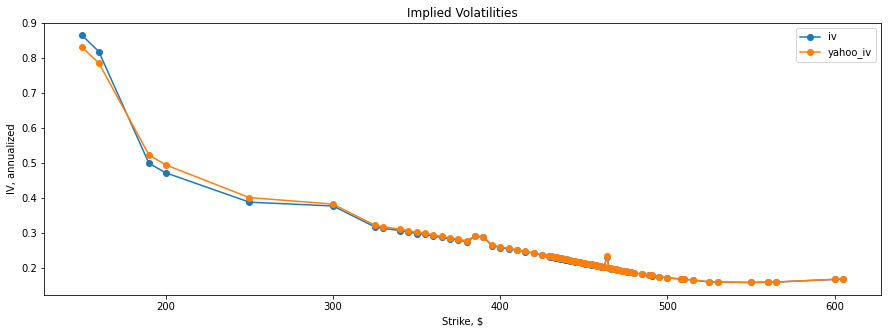

In [23]:
_, ax = plt.subplots(figsize=(15, 5))

print("Mean squared error: {:.5f}".format(np.mean((df["iv"] - df["yahoo_iv"])**2)))

for col in ("iv", "yahoo_iv"):
    ax.plot(df["strike"], df[col], "o-", label=col)
ax.legend()
ax.set_xlabel("Strike, $")
ax.set_ylabel("IV, annualized")
ax.set_title("Implied Volatilities")
plt.show()

**2. Newton Bisection Hybrid (Newt-Safe) (30 extra points)**

Implement the root finding algorithm as in https://www.youtube.com/watch?v=FD3BPTMGJds. Comment on the results and compare them with previous. 

In [24]:
#YOUR CODE HERE


    
def saveNewton(f,fprime,a,b,eps=1e-10):
    if (np.sign(f(a))==np.sign(f(b))):
        print("No root on [a,b]")
        return None
        
    def bisection(a,b):
        x=(a+b)/2
        return x
    
    def shrink_ab(x,a,b):
        if (np.sign(f(a))==np.sign(f(x))):
            return (x,b)
        return (a,x)
    
    x=(a+b)/2

    
    while (b-a)>eps:
        if np.abs(f(x))<eps:
            return x
        
        if (fprime(x)==0):
            xnew=biscetion(a,b)
            a,b=shrink_ab(xnew,a,b)
        else:
            xnew=x-f(x)/fprime(x)
            if (xnew>=b or xnew<=a or np.abs(2*f(xnew)) >np.abs(xnew-x)*fprime(xnew)):
                xnew=bisection(a,b)
                a,b=shrink_ab(xnew,a,b)
            else:
                a,b=shrink_ab(xnew,a,b)
        x=xnew
    return (a+b)/2


#проверяем метод для f(x)=3*(x-1.75)**2       
saveNewton(lambda x: (x-1.75)**3,lambda x: 3*(x-1.75)**2,1,2)

1.75

In [25]:
def calc_ivSAVE_NEWTON(option: CallStockOption, state: MarketState, market_option_price: float):
    """Calculates implied volatility
    
    Args:
        option (CallStockOption): call option parameters, 
            call is used due to the uniqueness of the solution
        state (MarketState): market state, volatility parameter is ignored
        market_option_price (float): actual option price
    
    Returns:
        float: volatility that produced passed option price
    """
    
    # YOUR CODE HERE
    def f(sigma):
        stateWithThisVolatility=MarketState(stock_price=state.stock_price, volatility=sigma,interest_rate=state.interest_rate)
        return price(option,stateWithThisVolatility)-market_option_price
    
    def fprime(sigma):
        stateWithThisVolatility=MarketState(stock_price=state.stock_price, volatility=sigma,interest_rate=state.interest_rate)
        return vega(option,stateWithThisVolatility)
    
    return saveNewton(f,fprime,0,100)

for idx, row in df.iterrows():
    option = CallStockOption(strike_price=row["strike"],
                             expiration_time=row["time_to_expiration"])
    df.at[idx, "ivSAVENEWTON"] = calc_ivSAVE_NEWTON(option, market_state, row["price"])
    
df

/Users/aleksandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


,strike,price,yahoo_iv,stock_price,time_to_expiration,iv,ivSAVENEWTON
0,150.0,288.73,0.8307,430.78,0.83,0.864901,0.864901
1,160.0,278.77,0.7858,430.78,0.83,0.818332,0.818332
2,190.0,242.60,0.5232,430.78,0.83,0.499116,0.499116
3,200.0,232.63,0.4950,430.78,0.83,0.472400,0.472400
4,250.0,183.87,0.4016,430.78,0.83,0.388529,0.388529
...,...,...,...,...,...,...,...
86,550.0,1.34,0.1594,430.78,0.83,0.159249,0.159249
87,560.0,1.02,0.1601,430.78,0.83,0.159980,0.159980
88,565.0,0.89,0.1605,430.78,0.83,0.160376,0.160376
89,600.0,0.42,0.1681,430.78,0.83,0.168049,0.168049


### Столбики iv и ivSAVENEWTON - одинаковые! Ура!